# **Corrective RAG (CRAG)**

**Corrective-RAG (CRAG)** is a strategy for RAG that incorporates **self-reflection / self-grading** on retrieved documents.

In the paper [here](https://arxiv.org/pdf/2401.15884), a few steps are taken:

- If at least one document exceeds the threshold for relevance, then it proceeds to generation.
- Before generation, it performs knowledge refinement.
- This partitions the document into "knowledge strips".
- It grades each strip, and filters our irrelevant ones.
- If all documents fall below the relevance threshold or if the grader is unsure, then the framework seeks an additional datasource.
- It will use web search to supplement retrieval.

**We will implement some of these ideas from scratch using LangGraph:**

- First, let's skip the knowledge refinement phase as a first pass. This can be added back as a node, if desired.
- If any documents are irrelevant, let's opt to supplement retrieval with web search.
- We'll use [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search/) for web search.
- Let's use query re-writing to optimize the query for web search.

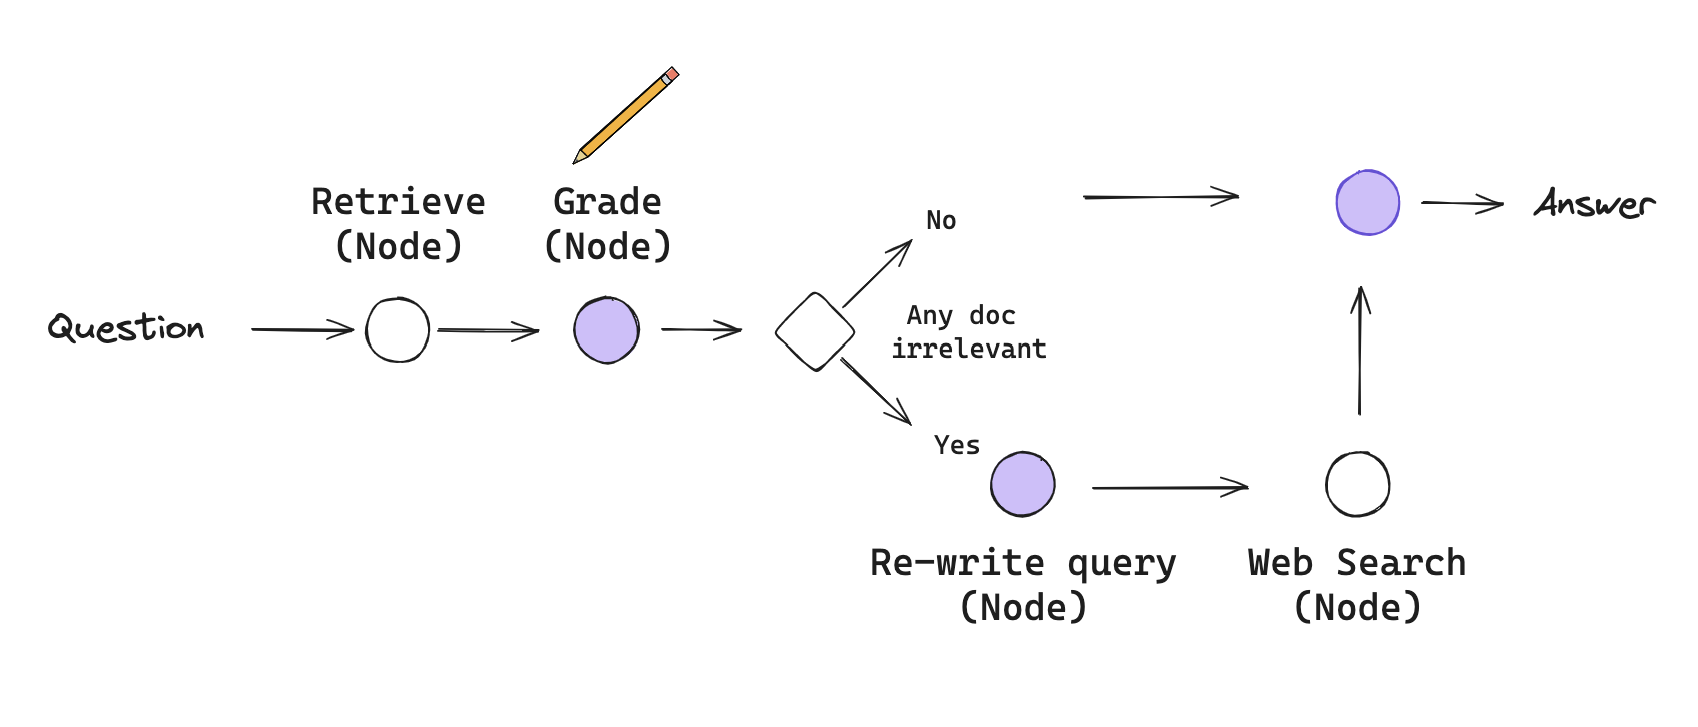

## **Setup**

**Load your API keys**

In [89]:
from dotenv import load_dotenv

load_dotenv()

True

## **LLM**

In [90]:
# local_llm = "llama3.2"
groq_llm = "llama-3.1-70b-versatile"

## **Create an Index**

We will index 3 blog posts.

In [91]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

from langchain.embeddings import HuggingFaceBgeEmbeddings
import pickle

In [92]:
### Load the data (blog posts) ###

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]


### Split the data into chunks ###
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)


### Store in a vectorDB ###

# Load an existing (saved) embedding model from a pickle file
with open('embedding_model.pkl', 'rb') as f:
    embedding_model = pickle.load(f)


vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="crag-chroma",
    embedding=embedding_model,
)
retriever = vectorstore.as_retriever()

## **Define the different nodes**

### **Retrieval Grader**

In [93]:
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_groq import ChatGroq

In [94]:
# LLM
# llm = ChatOllama(model=local_llm, format="json", temperature=0,)
llm = ChatGroq(model=groq_llm, temperature=0)

# Prompt
retrieval_grader_prompt = PromptTemplate(
    template="""You are an expert at grading the relevance of a document to a question. You will be given: 
    1/ a QUESTION
    2/ A document

    Give A score of "yes" if ANY of the statements in the document are relevant to the QUESTION. 
    Give a score of "no" if NONE of the statements in the document are relevant to the QUESTION. 


    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 

    Avoid simply stating the correct answer at the outset.

    Question: {question} \n
    Fact: \n\n {documents} \n\n

    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    You must only Provide the binary score as a JSON with a single key 'score' and no premable or explanation whatsoever.
    """,
    input_variables=["question", "documents"],
)

retrieval_grader = retrieval_grader_prompt | llm | JsonOutputParser()

In [95]:
## Test Retrievel 

question = "agent memory"
docs = retriever.invoke(question)

doc_txt = docs[1].page_content

retrieval_grade = retrieval_grader.invoke({"question": question, "documents": doc_txt})
print(retrieval_grade, type(retrieval_grade))

{'score': 'yes'} <class 'dict'>


In [96]:
docs[1].page_content

"Each element is an observation, an event directly provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval model: surfaces the context to inform the agent’s behavior, according to relevance, recency and importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are higher-level summaries of past events (<- note that this is a bit different from self-reflection above)\n\nPrompt LM with 100 most recent observations and to generate 3 most salient high-level questions given a set of observations/statements. Then ask LM to answer those questions.\n\n\nPlanning & Reacting: translate the reflections and the environment information into actions\n\nPlanning is essentially

### **Gererate**

In [97]:
from langchain_core.output_parsers import StrOutputParser

In [98]:
# Prompt
generation_prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks based on provided document. 

    Use the provided documents to answer the question. 

    If the documnent does not contain any relevant information to the qestion, just say that "I am unable to 
    answer because I don't have enough information." You must not make up an answer.


    Use three sentences maximum and keep the answer concise:
    
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM
# llm = ChatOllama(model=local_llm, temperature=0)
llm = ChatGroq(model=groq_llm, temperature=0)

# Chain
rag_chain = generation_prompt | llm | StrOutputParser()

In [99]:
### Test Generation

generation = rag_chain.invoke({"documents": docs, "question": question})

print(generation, type(generation))

The agent has two types of memory: short-term memory, which is utilized through in-context learning, and long-term memory, which allows the agent to retain and recall information over extended periods using an external vector store and fast retrieval. <class 'str'>


### **Question Rewriter**

In [100]:
### Question Re-writer

# LLM
# llm = ChatOllama(model=local_llm, temperature=0)
llm = ChatGroq(model=groq_llm, temperature=0)

# Prompt

re_write_prompt = PromptTemplate(
    template="""You are a question re-writer that converts an input question to a better version that is optimized \n 
     for web search using the following steps:

     - Identify the key words in the original question.
     - try to reason about the underlying semantic intent / meaning
     - Using the key words and the semantic intent, formulate a refined question which will be used in a web search.
    
     
     Here is the initial question:{question} 
     
     Formulate an improved question.

     You must only provide the improved question without any explanation whatsoever.
     
     """,
     input_variables=["question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()


In [101]:
## Test

question_rewriter.invoke({"question": question})


'What is agent memory in artificial intelligence?'

### **Search**

In [102]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

## **Create the Graph**


Now let's create our graph that will use CRAG

In [103]:
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph

### **Define Graph State**

In [104]:

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]

### **Define the Nodes**

**Retrieve Node**

In [105]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """

    print("---RETRIEVE---")
    
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")

    return {"documents": documents, "question": question, "steps": steps}

**Generate Node**

In [79]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    print("---GENERATE---")

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }

**Document Grader Node**

In [106]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")

    filtered_docs = []
    search = "No"

    for doc in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": doc.page_content}
        )
        grade = score["score"]
        
        if grade == "yes":
            filtered_docs.append(doc)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }

**Query Transform Node**

In [107]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    
    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("transform_query")

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})

    return {"documents": documents, "question": better_question, "steps":steps}

**Web Search Node**

In [108]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")

    web_results = web_search_tool.invoke({"query": question})

    documents.extend(
        [
            Document(page_content=doc["content"], metadata={"url": doc["url"]})
            for doc in web_results
        ]
    )

    return {"documents": documents, "question": question, "steps": steps}

### **Define the COnditional Edges**

In [109]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["search"]
    

    if web_search == "Yes":
        # All documents have been filtered with check_relevance and some or all are not relevant
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### **Compile the Graph**

In [110]:

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
graph = workflow.compile()

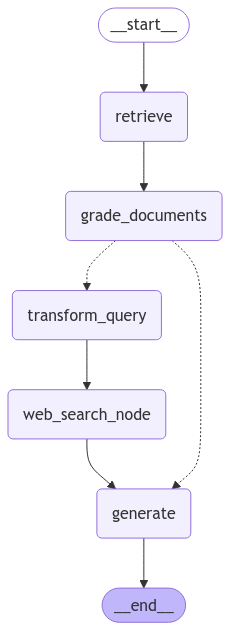

In [111]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


### **Use the Graph**

In [112]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of agent memory?", "steps": []}

for output in graph.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The different types of memory in artificial intelligence agents include '
 'short-term memory and long-term memory. Short-term memory refers to '
 'in-context learning, while long-term memory provides the capability to '
 'retain and recall information over extended periods, often by leveraging an '
 'external vector store and fast retrieval.')


In [113]:
from pprint import pprint

# Run
inputs = {"question": "How does the AlphaCodium paper work?", "steps": []}
for output in graph.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
("The AlphaCodium paper's technical explanation and implementation details can "
 'be found in the provided documents. According to the documents, AlphaCodium '
 'is a test-based, multi-stage, code-oriented iterative flow that improves the '
 'performances of LLMs on code problems. The implementation details include a '
 'modular code generation approach, where the model is asked to divide the '
 'generated code into small sub-functions with meaningful names and '
 'functionality, and a double validation process to correct errors.')
